In [1]:
import numpy as np
from paramagpy import protein, dataparse, fit, metal
import matplotlib as mt
import copy as c
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit as cf
import scipy.stats as sct
from tqdm import tqdm
import multiprocessing
import warnings
from Bio import PDB
from Bio.PDB.PDBExceptions import PDBConstructionWarning
warnings.simplefilter('ignore', PDBConstructionWarning)
from sklearn.model_selection import train_test_split as splt

In [2]:
def get_pcs(path, fr, pcs):
    coords = protein.load_pdb(f'{path}/fr{fr}.pdb')
    parsed = coords.parse(pcs)
    mstart = metal.Metal()
    mstart.position = coords[0]['A'][195]['CA'].position
    [guess], [data] = fit.svd_gridsearch_fit_metal_from_pcs([mstart], [parsed], 
                                                            radius=10, points=10, verbose=False)
    [mfit], [data] = fit.nlr_fit_metal_from_pcs([guess], [parsed])
    return data['cal']

def get_ranges(nobs, ncpus):
    starts = np.arange(0, nobs, nobs//ncpus)[:-1]
    ends = np.empty((ncpus))
    ends[:-1] = starts[1:]
    ends[-1] = nobs
    return starts.astype(int), ends.astype(int)

## HN 

In [4]:
dists_ = np.load('saved_pcs/2_output_files/dists_static.npy')
frames = np.where(np.sum((dists_>=5.5) & (dists_<=10.5), axis=1)==2)[0]
pcs = dataparse.read_pcs('saved_pcs/0_data_from_ubbink/static_exp_closed_HN.npc')

prefix = 'saved_pcs/1_frames_individual/fr'
suffix = '.pdb'

nobs = len(frames)
npcs = len(pcs)
ncpus = 16

def worker(start, end, sa1):
    for a in range(start,end):
        coords = protein.load_pdb(f'{prefix}{frames[a]}{suffix}')
        parsed = coords.parse(pcs)
        mstart = metal.Metal()
        mstart.position = coords[0]['A'][195]['CA'].position
        [guess], [data] = fit.svd_gridsearch_fit_metal_from_pcs([mstart], [parsed], 
                                                                radius=10, points=10, verbose=False)
        [mfit], [data] = fit.nlr_fit_metal_from_pcs([guess], [parsed])
        #
        sa1[a*npcs:(a+1)*npcs] = data['cal']
        #

if __name__ == '__main__':
    starts, ends = get_ranges(nobs, ncpus)
    #
    sa1 = multiprocessing.Array('d', nobs*len(pcs))
    #
    processes = []
    for job in range(ncpus):
        p = multiprocessing.Process(target=worker, 
                                    args=(starts[job], ends[job], sa1),
                                   )
        processes.append(p)
        p.start()
    #
    for p in processes:
        p.join()
    #
    cal = np.frombuffer(sa1.get_obj())

In [10]:
means = cal.reshape(nobs,npcs)
stds = np.mean(np.square(means), axis=0)
means = np.mean(means, axis=0)
stds = stds - np.square(means)

In [22]:
np.save('saved_pcs/2_output_files/means_HN.npy', means)
np.save('saved_pcs/2_output_files/stds_HN.npy', stds)

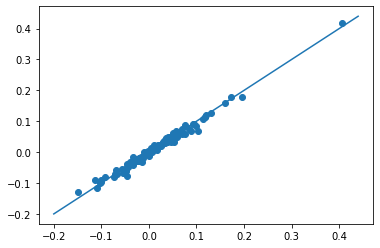

In [18]:
plt.scatter(np.array(list(pcs.values()))[:,0], means)
plt.plot([-0.2,0.44], [-0.2,0.44])

## N-H substrate free

In [23]:
dists_ = np.load('saved_pcs/2_output_files/dists_substrate-free.npy')
frames = np.where(np.sum((dists_>=5.5) & (dists_<=10.5), axis=1)==2)[0]
pcs = dataparse.read_pcs('saved_pcs/0_data_from_ubbink/observed_pcs_substrate-free_errors.npc')

prefix = 'saved_pcs/1_frames_individual/fr'
suffix = '.pdb'

nobs = len(frames)
npcs = len(pcs)
ncpus = 24

def worker(start, end, sa1):
    for a in range(start,end):
        coords = protein.load_pdb(f'{prefix}{frames[a]}{suffix}')
        parsed = coords.parse(pcs)
        mstart = metal.Metal()
        mstart.position = coords[0]['A'][195]['CA'].position
        [guess], [data] = fit.svd_gridsearch_fit_metal_from_pcs([mstart], [parsed], 
                                                                radius=10, points=10, verbose=False)
        [mfit], [data] = fit.nlr_fit_metal_from_pcs([guess], [parsed])
        #
        sa1[a*npcs:(a+1)*npcs] = data['cal']
        #

if __name__ == '__main__':
    starts, ends = get_ranges(nobs, ncpus)
    #
    sa1 = multiprocessing.Array('d', nobs*len(pcs))
    #
    processes = []
    for job in range(ncpus):
        p = multiprocessing.Process(target=worker, 
                                    args=(starts[job], ends[job], sa1),
                                   )
        processes.append(p)
        p.start()
    #
    for p in processes:
        p.join()
    #
    cal = np.frombuffer(sa1.get_obj())
    
means = cal.reshape(nobs,npcs)
stds = np.mean(np.square(means), axis=0)
means = np.mean(means, axis=0)
stds = stds - np.square(means)

Line ignored while reading file: saved_pcs/0_data_from_ubbink/observed_pcs_substrate-free_errors.npc
134 N 

Line ignored while reading file: saved_pcs/0_data_from_ubbink/observed_pcs_substrate-free_errors.npc
289 N 



In [24]:
np.save('saved_pcs/2_output_files/means_substrate-free.npy', means)
np.save('saved_pcs/2_output_files/stds_substrate-free.npy', stds)

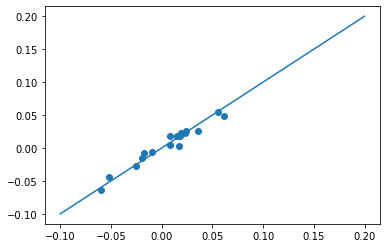

In [26]:
plt.scatter(np.array(list(pcs.values()))[:,0], means)
plt.plot([-0.1,0.2], [-0.1,0.2])

## +cam

In [27]:
dists_ = np.load('saved_pcs/2_output_files/dists_with_cam.npy')
frames = np.where(np.sum((dists_>=5.5) & (dists_<=10.5), axis=1)==2)[0]
pcs = dataparse.read_pcs('saved_pcs/0_data_from_ubbink/observed_pcs_with_cam_errors.npc')

prefix = 'saved_pcs/1_frames_individual/fr'
suffix = '.pdb'

nobs = len(frames)
npcs = len(pcs)
ncpus = 24

def worker(start, end, sa1):
    for a in range(start,end):
        coords = protein.load_pdb(f'{prefix}{frames[a]}{suffix}')
        parsed = coords.parse(pcs)
        mstart = metal.Metal()
        mstart.position = coords[0]['A'][195]['CA'].position
        [guess], [data] = fit.svd_gridsearch_fit_metal_from_pcs([mstart], [parsed], 
                                                                radius=10, points=10, verbose=False)
        [mfit], [data] = fit.nlr_fit_metal_from_pcs([guess], [parsed])
        #
        sa1[a*npcs:(a+1)*npcs] = data['cal']
        #

if __name__ == '__main__':
    starts, ends = get_ranges(nobs, ncpus)
    #
    sa1 = multiprocessing.Array('d', nobs*len(pcs))
    #
    processes = []
    for job in range(ncpus):
        p = multiprocessing.Process(target=worker, 
                                    args=(starts[job], ends[job], sa1),
                                   )
        processes.append(p)
        p.start()
    #
    for p in processes:
        p.join()
    #
    cal = np.frombuffer(sa1.get_obj())
    
means = cal.reshape(nobs,npcs)
stds = np.mean(np.square(means), axis=0)
means = np.mean(means, axis=0)
stds = stds - np.square(means)

In [28]:
np.save('saved_pcs/2_output_files/means_with_cam.npy', means)
np.save('saved_pcs/2_output_files/stds_with_cam.npy', stds)

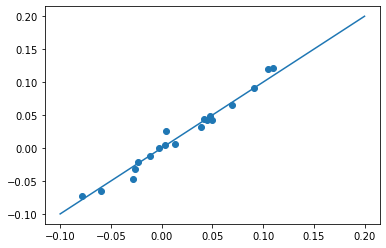

In [29]:
plt.scatter(np.array(list(pcs.values()))[:,0], means)
plt.plot([-0.1,0.2], [-0.1,0.2])

## +pdx

In [30]:
dists_ = np.load('saved_pcs/2_output_files/dists_with_pdx.npy')
frames = np.where(np.sum((dists_>=5.5) & (dists_<=10.5), axis=1)==2)[0]
pcs = dataparse.read_pcs('saved_pcs/0_data_from_ubbink/observed_pcs_with_cam_pdx_errors.npc')

prefix = 'saved_pcs/1_frames_individual/fr'
suffix = '.pdb'

nobs = len(frames)
npcs = len(pcs)
ncpus = 24

def worker(start, end, sa1):
    for a in range(start,end):
        coords = protein.load_pdb(f'{prefix}{frames[a]}{suffix}')
        parsed = coords.parse(pcs)
        mstart = metal.Metal()
        mstart.position = coords[0]['A'][195]['CA'].position
        [guess], [data] = fit.svd_gridsearch_fit_metal_from_pcs([mstart], [parsed], 
                                                                radius=10, points=10, verbose=False)
        [mfit], [data] = fit.nlr_fit_metal_from_pcs([guess], [parsed])
        #
        sa1[a*npcs:(a+1)*npcs] = data['cal']
        #

if __name__ == '__main__':
    starts, ends = get_ranges(nobs, ncpus)
    #
    sa1 = multiprocessing.Array('d', nobs*len(pcs))
    #
    processes = []
    for job in range(ncpus):
        p = multiprocessing.Process(target=worker, 
                                    args=(starts[job], ends[job], sa1),
                                   )
        processes.append(p)
        p.start()
    #
    for p in processes:
        p.join()
    #
    cal = np.frombuffer(sa1.get_obj())
    
means = cal.reshape(nobs,npcs)
stds = np.mean(np.square(means), axis=0)
means = np.mean(means, axis=0)
stds = stds - np.square(means)

In [31]:
np.save('saved_pcs/2_output_files/means_with_pdx.npy', means)
np.save('saved_pcs/2_output_files/stds_with_pdx.npy', stds)

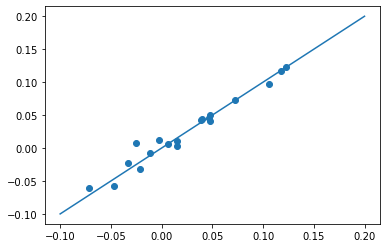

In [32]:
plt.scatter(np.array(list(pcs.values()))[:,0], means)
plt.plot([-0.1,0.2], [-0.1,0.2])